In [1]:
import baselineUtils
import torch
import individual_TF
import scipy.io
from transformer.batch import subsequent_mask
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import operator
import os
plt.rcParams["figure.figsize"] = (10,7)

In [2]:
def predict_traj(model, folder_name):
    test_dataset,_ =  baselineUtils.create_dataset('datasets',folder_name,0,8,12,
                                               '\t',train=False,eval=True,verbose='store_true')
    test_dl = torch.utils.data.DataLoader(test_dataset, 20, shuffle=False, num_workers=0)
    model.eval()
    gt = []
    pr = []
    inp_ = []
    peds = []
    frames = []
    dt = []
    norm = scipy.io.loadmat(f'models/Individual/merged_train/norm.mat')
    mean = norm['mean']
    std = norm['std']
    
    for id_b,batch in enumerate(test_dl):
                    inp_.append(batch['src'])
                    gt.append(batch['trg'][:,:,0:2])
                    frames.append(batch['frames'])
                    peds.append(batch['peds'])
                    dt.append(batch['dataset'])

                    inp = (batch['src'][:, 1:, 2:4].to(device) - mean) / std
                    src_att = torch.ones((inp.shape[0], 1, inp.shape[1])).to(device)
                    start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(1).repeat(inp.shape[0], 1, 1).to(
                        device)
                    dec_inp=start_of_seq

                    for i in range(12):
                        trg_att = subsequent_mask(dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)
                        out = model(inp, dec_inp, src_att, trg_att)
                        dec_inp=torch.cat((dec_inp,out[:,-1:,:]),1)


                    preds_tr_b=(dec_inp[:,1:,0:2].detach().numpy()*std+mean).cumsum(1)+batch['src'][:,-1:,0:2].cpu().numpy()
                    pr.append(preds_tr_b)
                    print("test epoch %03i/%03i  batch %04i / %04i" % (
                    20, 20, id_b, len(test_dl)))
                    
    peds = np.concatenate(peds, 0)
    frames = np.concatenate(frames, 0)
    dt = np.concatenate(dt, 0)
    gt = np.concatenate(gt, 0)
    dt_names = test_dataset.data['dataset_name']
    pr = np.concatenate(pr, 0)
    
    return peds, frames, dt, gt, dt_names, pr

In [3]:
device=torch.device("cpu")

In [4]:
model=individual_TF.IndividualTF(2, 3, 3, N=6,
                   d_model=512, d_ff=2048, h=8, dropout=0.1,mean=[0,0],std=[0,0]).to(device)

In [5]:
PATH = f'models/Individual/merged_train/00059.pth'

In [6]:
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [7]:
peds, frames, dt, gt, dt_names, pr = predict_traj(model, 'merged_data')

start loading dataset
validation set size -> 0
001 / 001 - loading mix_test_locations.txt
test epoch 020/020  batch 0000 / 0012
test epoch 020/020  batch 0001 / 0012
test epoch 020/020  batch 0002 / 0012
test epoch 020/020  batch 0003 / 0012
test epoch 020/020  batch 0004 / 0012
test epoch 020/020  batch 0005 / 0012
test epoch 020/020  batch 0006 / 0012
test epoch 020/020  batch 0007 / 0012
test epoch 020/020  batch 0008 / 0012
test epoch 020/020  batch 0009 / 0012
test epoch 020/020  batch 0010 / 0012
test epoch 020/020  batch 0011 / 0012


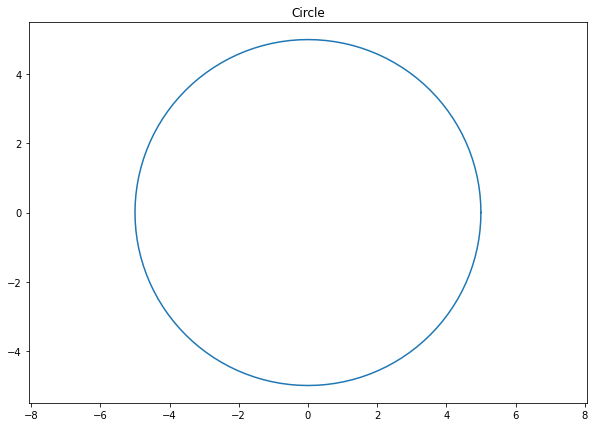

In [8]:
import numpy as np
from matplotlib import pyplot as plt

# Creating equally spaced 100 data in range 0 to 2*pi
theta = np.linspace(0, 2 * np.pi, 121)

# Setting radius
radius = 5

# Generating x and y data
x = radius * np.cos(theta)
y = radius * np.sin(theta)

# Plotting
plt.plot(x, y)
plt.axis('equal')
plt.title('Circle')
plt.show()

In [9]:
x = x + 6
y = y + 6
x = x * 50
y = y * 50

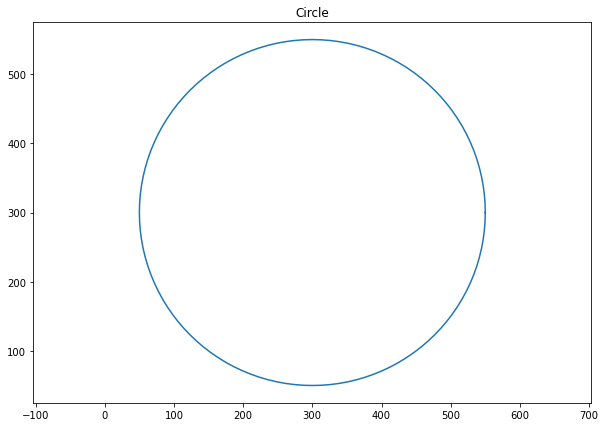

In [10]:
plt.plot(x, y)
plt.axis('equal')
plt.title('Circle')
plt.show()

In [11]:
time_step = 0

In [12]:
test_data = [[i, j] for i, j in zip(x[time_step:time_step + 20], y[time_step:time_step + 20])]

In [13]:
test_data[0]

[550.0, 300.0]

In [14]:
time_step = 0
test_data = [[i, j] for i, j in zip(x[time_step:time_step + 20], y[time_step:time_step + 20])]
full_gt = []
full_pr = []
for k in range(9):
    person = 1
    try:
        os.mkdir(f'datasets/merged_data_{time_step}')
        print("success")
    except:
        pass
    try:
        os.mkdir(f'datasets/merged_data_{time_step}/test')
        print("success")
    except:
        pass
    with open('datasets/merged_data_{}/test/test_locations_{}.txt'.format(time_step, time_step), 'w') as f:
        counter = 0
        for loc in test_data:
            counter = counter + 1 
            f.write("{}\t{}\t{}\t{}".format(counter, person, loc[0], loc[1]))
            f.write("\n")
    peds, frames, dt, gt, dt_names, pr = predict_traj(model, 'merged_data_{}'.format(time_step))    
    full_gt.append(gt)
    full_pr.append(pr)
    if time_step == 0:
        time_step += 20
    else:
        time_step += 12
    test_data = [[i, j] for i, j in zip(x[time_step-7:time_step + 13], y[time_step-7:time_step + 13])]

start loading dataset
validation set size -> 0
001 / 001 - loading test_locations_0.txt
test epoch 020/020  batch 0000 / 0001
start loading dataset
validation set size -> 0
001 / 001 - loading test_locations_20.txt
test epoch 020/020  batch 0000 / 0001
start loading dataset
validation set size -> 0
001 / 001 - loading test_locations_32.txt
test epoch 020/020  batch 0000 / 0001
start loading dataset
validation set size -> 0
001 / 001 - loading test_locations_44.txt
test epoch 020/020  batch 0000 / 0001
start loading dataset
validation set size -> 0
001 / 001 - loading test_locations_56.txt
test epoch 020/020  batch 0000 / 0001
start loading dataset
validation set size -> 0
001 / 001 - loading test_locations_68.txt
test epoch 020/020  batch 0000 / 0001
start loading dataset
validation set size -> 0
001 / 001 - loading test_locations_80.txt
test epoch 020/020  batch 0000 / 0001
start loading dataset
validation set size -> 0
001 / 001 - loading test_locations_92.txt
test epoch 020/020  bat

In [15]:
full_gt = np.array(full_gt)
full_pr = np.array(full_pr)
full_gt = full_gt.reshape(full_gt.shape[0], 12, 2)
full_pr = full_pr.reshape(full_pr.shape[0], 12, 2)

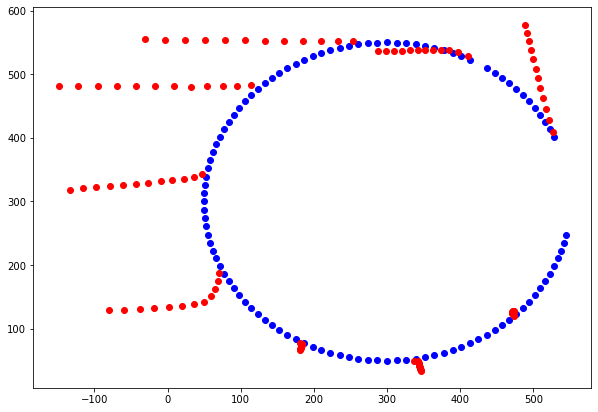

In [16]:
## plt.plot(full_gt.reshape(full_gt.shape[0] * full_gt.shape[2],2)[:,0], full_gt.reshape(full_gt.shape[0] * full_gt.shape[2],2)[:,1])
##plt.plot(full_pr.reshape(full_gt.shape[0] * full_gt.shape[2],2)[:,0], full_pr.reshape(full_gt.shape[0] * full_gt.shape[2],2)[:,1], color='r')

for i in range(9):
    plt.scatter(full_gt[i][:, 0], full_gt[i][:, 1], color='blue')
    plt.scatter(full_pr[i][:, 0], full_pr[i][:, 1], color='red')
plt.show()

In [17]:
time_step = 0
test_data = [[i, j] for i, j in zip(x[time_step:time_step + 20], y[time_step:time_step + 20])]
full_gt = []
full_pr = []
for k in range(9):
    print("The test data for ", k, " timestep is:")
    print(test_data)
    person = 1
    try:
        os.mkdir(f'datasets/merged_data_{time_step}')
        print("success")
    except:
        pass
    try:
        os.mkdir(f'datasets/merged_data_{time_step}/test')
        print("success")
    except:
        pass
    with open('datasets/merged_data_{}/test/test_locations_{}.txt'.format(time_step, time_step), 'w') as f:
        counter = 0
        for loc in test_data:
            counter = counter + 1 
            f.write("{}\t{}\t{}\t{}".format(counter, person, loc[0], loc[1]))
            f.write("\n")
    peds, frames, dt, gt, dt_names, pr = predict_traj(model, 'merged_data_{}'.format(time_step))    
    full_gt.append(gt)
    full_pr.append(pr)
    if time_step == 0:
        time_step += 20
    else:
        time_step += 12
    test_data = [[i, j] for i, j in zip(np.concatenate((pr.reshape(12,2)[5:,0], x[time_step:time_step + 13])), np.concatenate((pr.reshape(12,2)[5:,1], y[time_step:time_step + 13])))]

The test data for  0  timestep is:
[[550.0, 300.0], [549.6573836886434, 313.0839890607359], [548.6304738420683, 326.13211581691337], [546.9220851487845, 339.1086162600577], [544.5369001834514, 351.97792270443983], [541.481456572267, 364.7047612756302], [537.7641290737884, 377.25424859373686], [533.3951066243005, 389.59198738632506], [528.3863644106501, 401.68416076895], [522.751631047092, 413.4976249348867], [516.5063509461097, 425.0], [509.66764198635605, 436.15975875375676], [502.2542485937368, 446.94631307311835], [494.2864903642427, 457.33009776245933], [485.7862063693486, 467.28265158971453], [476.7766952966369, 476.7766952966369], [467.2826515897146, 485.7862063693485], [457.33009776245945, 494.2864903642427], [446.94631307311835, 502.2542485937368], [436.1597587537569, 509.66764198635593]]
start loading dataset
validation set size -> 0
001 / 001 - loading test_locations_0.txt
test epoch 020/020  batch 0000 / 0001
The test data for  1  timestep is:
[[506.23211669921875, 493.76885

test epoch 020/020  batch 0000 / 0001


In [18]:
x

array([550.        , 549.65738369, 548.63047384, 546.92208515,
       544.53690018, 541.48145657, 537.76412907, 533.39510662,
       528.38636441, 522.75163105, 516.50635095, 509.66764199,
       502.25424859, 494.28649036, 485.78620637, 476.7766953 ,
       467.28265159, 457.33009776, 446.94631307, 436.15975875,
       425.        , 413.49762493, 401.68416077, 389.59198739,
       377.25424859, 364.70476128, 351.9779227 , 339.10861626,
       326.13211582, 313.08398906, 300.        , 286.91601094,
       273.86788418, 260.89138374, 248.0220773 , 235.29523872,
       222.74575141, 210.40801261, 198.31583923, 186.50237507,
       175.        , 163.84024125, 153.05368693, 142.66990224,
       132.71734841, 123.2233047 , 114.21379363, 105.71350964,
        97.74575141,  90.33235801,  83.49364905,  77.24836895,
        71.61363559,  66.60489338,  62.23587093,  58.51854343,
        55.46309982,  53.07791485,  51.36952616,  50.34261631,
        50.        ,  50.34261631,  51.36952616,  53.07

In [19]:
full_gt = np.array(full_gt)
full_pr = np.array(full_pr)
full_gt = full_gt.reshape(full_gt.shape[0], 12, 2)
full_pr = full_pr.reshape(full_pr.shape[0], 12, 2)

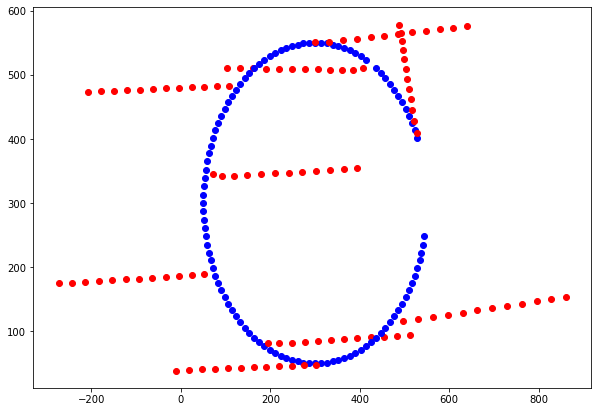

In [20]:
for i in range(9):
    plt.scatter(full_gt[i][:, 0], full_gt[i][:, 1], color='blue')
    plt.scatter(full_pr[i][:, 0], full_pr[i][:, 1], color='red')
plt.show()

## 1.) Apply Poly regression to the known trajectory
## 2.) Shift the predicted points towards the regression line

The test data for  0  timestep is:
[[550.         300.        ]
 [549.65738369 313.08398906]
 [548.63047384 326.13211582]
 [546.92208515 339.10861626]
 [544.53690018 351.9779227 ]
 [541.48145657 364.70476128]
 [537.76412907 377.25424859]
 [533.39510662 389.59198739]
 [528.38636441 401.68416077]
 [522.75163105 413.49762493]
 [516.50635095 425.        ]
 [509.66764199 436.15975875]
 [502.25424859 446.94631307]
 [494.28649036 457.33009776]
 [485.78620637 467.28265159]
 [476.7766953  476.7766953 ]
 [467.28265159 485.78620637]
 [457.33009776 494.28649036]
 [446.94631307 502.25424859]
 [436.15975875 509.66764199]]
start loading dataset
validation set size -> 0
001 / 001 - loading test_locations_0.txt
test epoch 020/020  batch 0000 / 0001


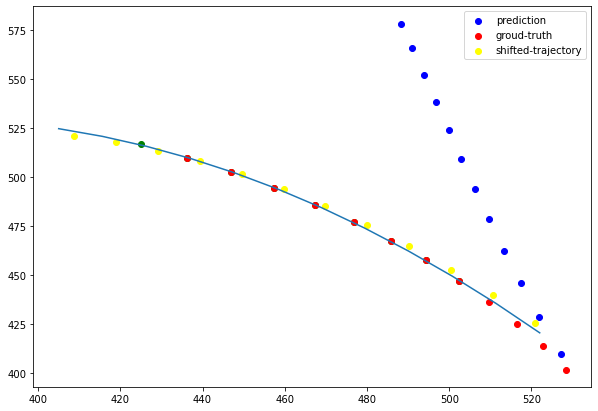

The test data for  1  timestep is:
[[459.68338013 493.78399658]
 [469.88516235 485.08865356]
 [480.09109497 475.31048584]
 [490.30038452 464.44805908]
 [500.51269531 452.49755859]
 [510.72836304 439.45428467]
 [520.94805908 425.31591797]
 [425.         516.50635095]
 [413.49762493 522.75163105]
 [401.68416077 528.38636441]
 [389.59198739 533.39510662]
 [377.25424859 537.76412907]
 [364.70476128 541.48145657]
 [351.9779227  544.53690018]
 [339.10861626 546.92208515]
 [326.13211582 548.63047384]
 [313.08398906 549.65738369]
 [300.         550.        ]
 [286.91601094 549.65738369]
 [273.86788418 548.63047384]]
start loading dataset
validation set size -> 0
001 / 001 - loading test_locations_20.txt
test epoch 020/020  batch 0000 / 0001


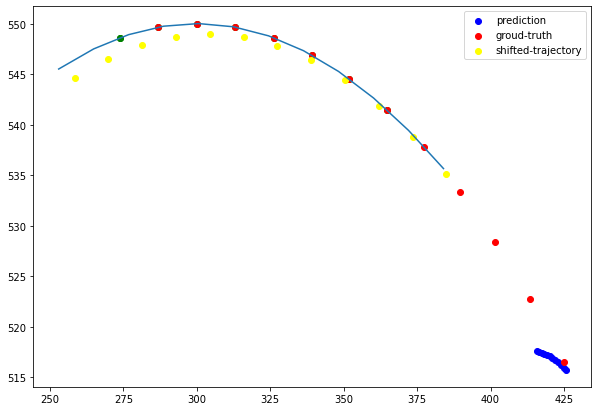

The test data for  2  timestep is:
[[315.93533325 548.67132568]
 [327.4430542  547.80822754]
 [338.95184326 546.38537598]
 [350.4614563  544.40283203]
 [361.97174072 541.86071777]
 [373.4826355  538.75909424]
 [384.99404907 535.0980835 ]
 [273.86788418 548.63047384]
 [260.89138374 546.92208515]
 [248.0220773  544.53690018]
 [235.29523872 541.48145657]
 [222.74575141 537.76412907]
 [210.40801261 533.39510662]
 [198.31583923 528.38636441]
 [186.50237507 522.75163105]
 [175.         516.50635095]
 [163.84024125 509.66764199]
 [153.05368693 502.25424859]
 [142.66990224 494.28649036]
 [132.71734841 485.78620637]]
start loading dataset
validation set size -> 0
001 / 001 - loading test_locations_32.txt
test epoch 020/020  batch 0000 / 0001


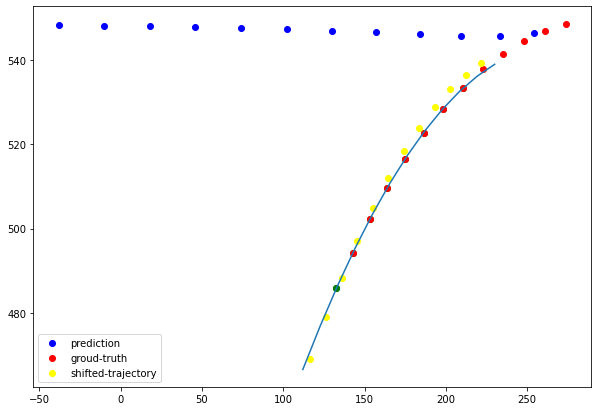

The test data for  3  timestep is:
[[164.51582336 511.91189575]
 [174.03904724 518.29888916]
 [183.55670166 523.95349121]
 [193.072052   528.8762207 ]
 [202.58711243 533.06768799]
 [212.10299683 536.52813721]
 [221.61990356 539.25799561]
 [132.71734841 485.78620637]
 [123.2233047  476.7766953 ]
 [114.21379363 467.28265159]
 [105.71350964 457.33009776]
 [ 97.74575141 446.94631307]
 [ 90.33235801 436.15975875]
 [ 83.49364905 425.        ]
 [ 77.24836895 413.49762493]
 [ 71.61363559 401.68416077]
 [ 66.60489338 389.59198739]
 [ 62.23587093 377.25424859]
 [ 58.51854343 364.70476128]
 [ 55.46309982 351.9779227 ]]
start loading dataset
validation set size -> 0
001 / 001 - loading test_locations_44.txt
test epoch 020/020  batch 0000 / 0001


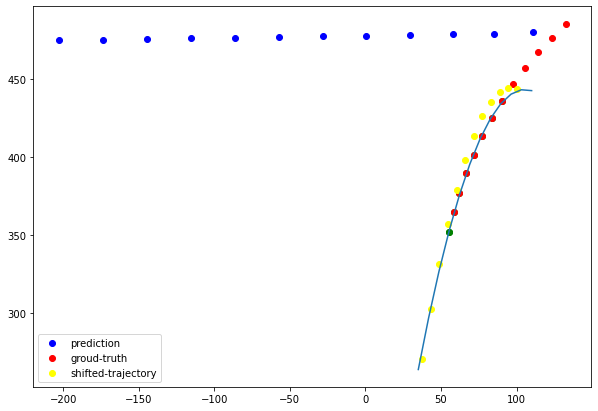

The test data for  4  timestep is:
[[ 66.04707336 398.11590576]
 [ 71.7452774  413.87054443]
 [ 77.44107819 426.36584473]
 [ 83.13535309 435.60165405]
 [ 88.82931519 441.57809448]
 [ 94.52384186 444.29537964]
 [100.21913147 443.75375366]
 [ 55.46309982 351.9779227 ]
 [ 53.07791485 339.10861626]
 [ 51.36952616 326.13211582]
 [ 50.34261631 313.08398906]
 [ 50.         300.        ]
 [ 50.34261631 286.91601094]
 [ 51.36952616 273.86788418]
 [ 53.07791485 260.89138374]
 [ 55.46309982 248.0220773 ]
 [ 58.51854343 235.29523872]
 [ 62.23587093 222.74575141]
 [ 66.60489338 210.40801261]
 [ 71.61363559 198.31583923]]
start loading dataset
validation set size -> 0
001 / 001 - loading test_locations_56.txt
test epoch 020/020  batch 0000 / 0001


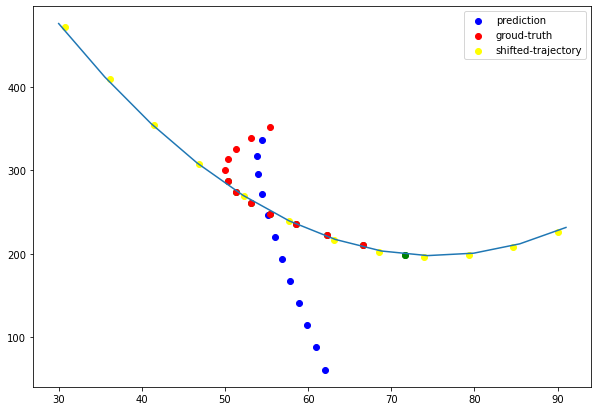

The test data for  5  timestep is:
[[ 57.67245865 238.69422913]
 [ 63.07299805 216.29902649]
 [ 68.47550964 202.01818848]
 [ 73.87913513 195.85678101]
 [ 79.28336334 197.81771851]
 [ 84.68801117 207.90219116]
 [ 90.0929718  226.1104126 ]
 [ 71.61363559 198.31583923]
 [ 77.24836895 186.50237507]
 [ 83.49364905 175.        ]
 [ 90.33235801 163.84024125]
 [ 97.74575141 153.05368693]
 [105.71350964 142.66990224]
 [114.21379363 132.71734841]
 [123.2233047  123.2233047 ]
 [132.71734841 114.21379363]
 [142.66990224 105.71350964]
 [153.05368693  97.74575141]
 [163.84024125  90.33235801]
 [175.          83.49364905]]
start loading dataset
validation set size -> 0
001 / 001 - loading test_locations_68.txt
test epoch 020/020  batch 0000 / 0001


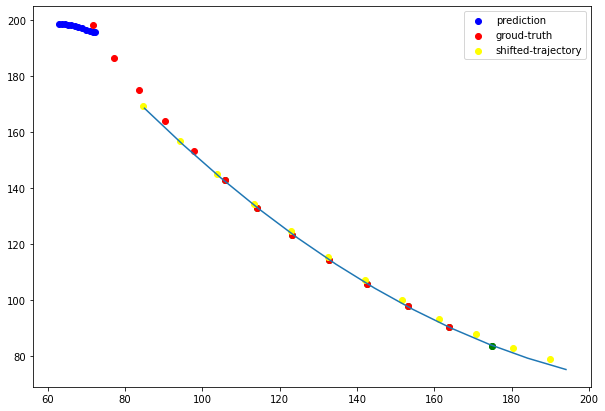

The test data for  6  timestep is:
[[132.46322632 115.32054138]
 [142.03340149 107.10751343]
 [151.60484314  99.75270081]
 [161.17744446  93.25642395]
 [170.75102234  87.61894226]
 [180.32546997  82.84060669]
 [189.90065002  78.92204285]
 [175.          83.49364905]
 [186.50237507  77.24836895]
 [198.31583923  71.61363559]
 [210.40801261  66.60489338]
 [222.74575141  62.23587093]
 [235.29523872  58.51854343]
 [248.0220773   55.46309982]
 [260.89138374  53.07791485]
 [273.86788418  51.36952616]
 [286.91601094  50.34261631]
 [300.          50.        ]
 [313.08398906  50.34261631]
 [326.13211582  51.36952616]]
start loading dataset
validation set size -> 0
001 / 001 - loading test_locations_80.txt
test epoch 020/020  batch 0000 / 0001


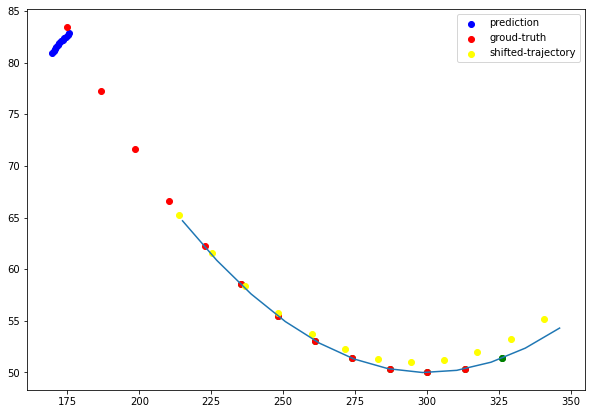

The test data for  7  timestep is:
[[271.3659668   52.26355743]
 [282.88543701  51.34335327]
 [294.40570068  50.98203278]
 [305.92663574  51.17959595]
 [317.4480896   51.93593216]
 [328.97006226  53.25102997]
 [340.49249268  55.12508392]
 [326.13211582  51.36952616]
 [339.10861626  53.07791485]
 [351.9779227   55.46309982]
 [364.70476128  58.51854343]
 [377.25424859  62.23587093]
 [389.59198739  66.60489338]
 [401.68416077  71.61363559]
 [413.49762493  77.24836895]
 [425.          83.49364905]
 [436.15975875  90.33235801]
 [446.94631307  97.74575141]
 [457.33009776 105.71350964]
 [467.28265159 114.21379363]]
start loading dataset
validation set size -> 0
001 / 001 - loading test_locations_92.txt
test epoch 020/020  batch 0000 / 0001


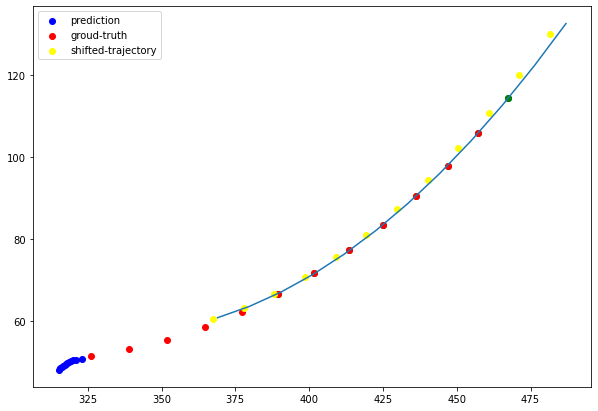

The test data for  8  timestep is:
[[419.37091064  81.05043793]
 [429.74734497  87.35092163]
 [440.12380981  94.38220978]
 [450.50033569 102.14420319]
 [460.87686157 110.63666534]
 [471.25350952 119.85949707]
 [481.63031006 129.81283569]
 [467.28265159 114.21379363]
 [476.7766953  123.2233047 ]
 [485.78620637 132.71734841]
 [494.28649036 142.66990224]
 [502.25424859 153.05368693]
 [509.66764199 163.84024125]
 [516.50635095 175.        ]
 [522.75163105 186.50237507]
 [528.38636441 198.31583923]
 [533.39510662 210.40801261]
 [537.76412907 222.74575141]
 [541.48145657 235.29523872]
 [544.53690018 248.0220773 ]]
start loading dataset
validation set size -> 0
001 / 001 - loading test_locations_104.txt
test epoch 020/020  batch 0000 / 0001


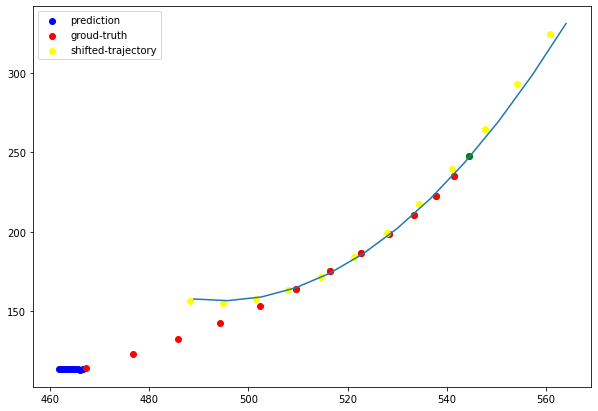

In [21]:
time_step = 0
test_data = np.array([[i, j] for i, j in zip(x[time_step:time_step + 20], y[time_step:time_step + 20])])
full_gt = []
full_pr = []
for k in range(9):
    print("The test data for ", k, " timestep is:")
    print(test_data)
    person = 1
    try:
        os.mkdir(f'datasets/merged_data_{time_step}')
        print("success")
    except:
        pass
    try:
        os.mkdir(f'datasets/merged_data_{time_step}/test')
        print("success")
    except:
        pass
    with open('datasets/merged_data_{}/test/test_locations_{}.txt'.format(time_step, time_step), 'w') as f:
        counter = 0
        for loc in test_data:
            counter = counter + 1 
            f.write("{}\t{}\t{}\t{}".format(counter, person, loc[0], loc[1]))
            f.write("\n")
    peds, frames, dt, gt, dt_names, pr = predict_traj(model, 'merged_data_{}'.format(time_step))
#     full_gt.append(gt)
#     full_pr.append(pr)
    if time_step == 0:
        time_step += 20
    else:
        time_step += 12
    loc_21timestep = np.array([x[time_step], y[time_step]])
    x_var = np.append(test_data[:,0][12:], loc_21timestep[0])
    y_var = np.append(test_data[:,1][12:], loc_21timestep[1])
    myline = np.linspace(int(min(x_var) - 20), int(max(x_var) + 20), 12)
    mymodel = np.poly1d(np.polyfit(x_var, y_var, 2))
    predicted_line = [[i, j] for i, j in zip(myline, mymodel(myline))]
    shifted_path = np.copy(pr[0])
#     for i in range(pr[0].shape[0]):
#         short_x = 0
#         short_y = 0
#         shortest_distance = 1000
#         for j in range(len(predicted_line)):
#             if shortest_distance > math.dist(pr[0][i], predicted_line[j]):
#                 shortest_distance = math.dist(pr[0][i], predicted_line[j])
#                 short_x = predicted_line[j][0]
#                 short_y = predicted_line[j][1]
#         print("Short distance: ", shortest_distance)
#         print("Short x: ", short_x)
#         print("Short y: ", short_y)
#         shifted_path[i] = np.array([abs(short_x+pr[0][i][0])/2, abs(short_y+pr[0][i][1])/2]).reshape(2)
    for i in range(5):
        for j in range(len(predicted_line)):
            shifted_path[j] = np.array([(shifted_path[j][0] + predicted_line[j][0])/2, (shifted_path[j][1] + predicted_line[j][1])/2])
    plt.scatter(x_var, y_var, color='green')
    plt.scatter(pr[0][:,0], pr[0][:,1], color='blue', label ='prediction')
    plt.scatter(x[time_step-12:time_step], y[time_step-12:time_step], color='red', label ='groud-truth')
    plt.scatter(shifted_path[:,0], shifted_path[:,1], color='yellow', label ='shifted-trajectory')
    plt.plot(myline, mymodel(myline))
    plt.legend()
    plt.show()
    full_gt.append(gt)
    full_pr.append(shifted_path)
    test_data = np.array([[i, j] for i, j in zip(np.concatenate((shifted_path.reshape(12,2)[5:,0], x[time_step:time_step + 13])), np.concatenate((shifted_path.reshape(12,2)[5:,1], y[time_step:time_step + 13])))])

In [22]:
full_gt = np.array(full_gt)
full_pr = np.array(full_pr)
full_gt = full_gt.reshape(full_gt.shape[0], 12, 2)
full_pr = full_pr.reshape(full_pr.shape[0], 12, 2)

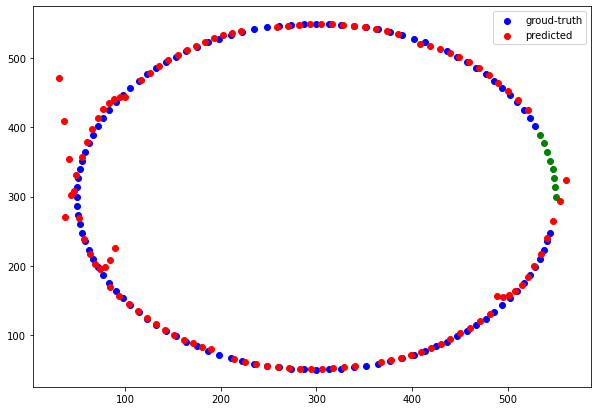

In [25]:
plt.scatter(x[:8], y[:8], color='green')
plt.scatter(full_gt.reshape(9*12,2)[:,0], full_gt.reshape(9*12,2)[:,1], color='blue', label ='groud-truth')
plt.scatter(full_pr.reshape(9*12,2)[:,0], full_pr.reshape(9*12,2)[:,1], color='red', label ='predicted')
plt.legend()
plt.show()

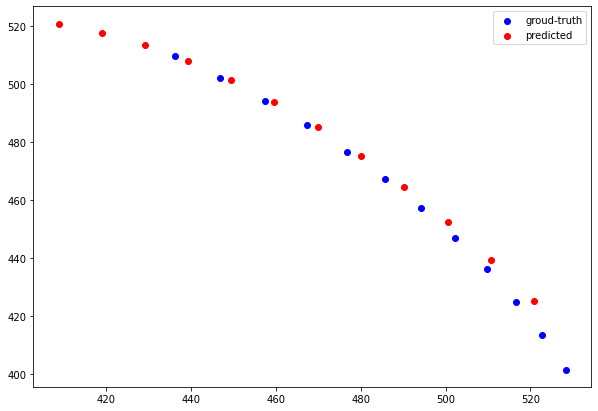

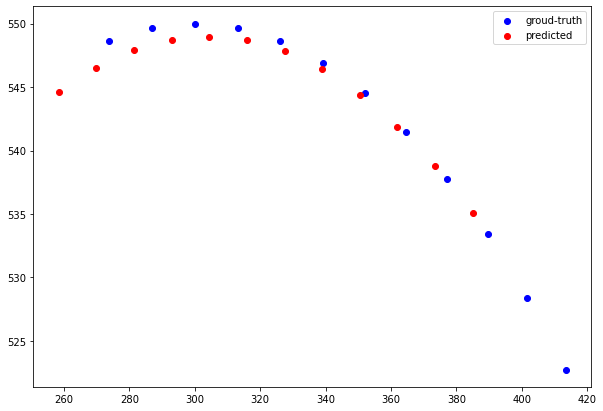

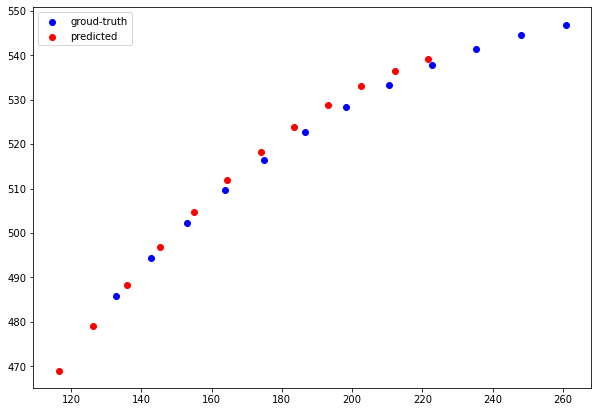

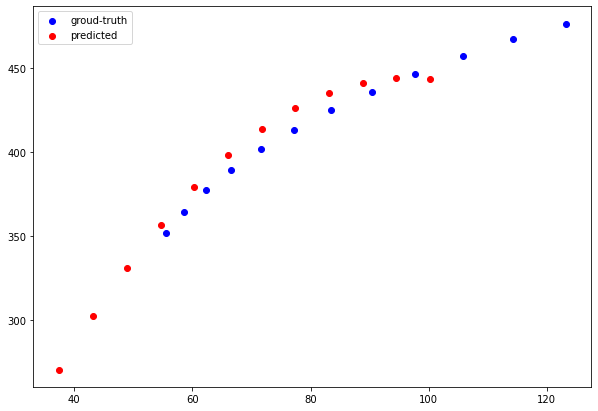

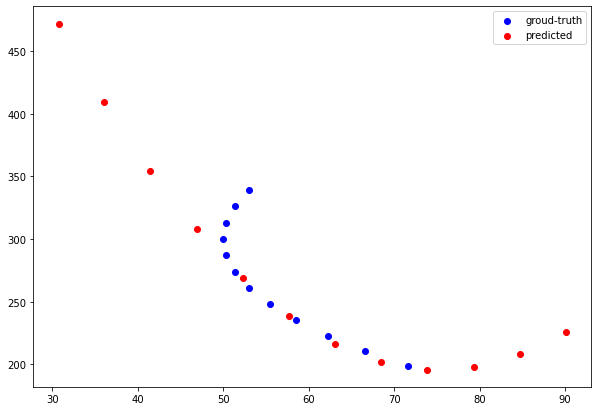

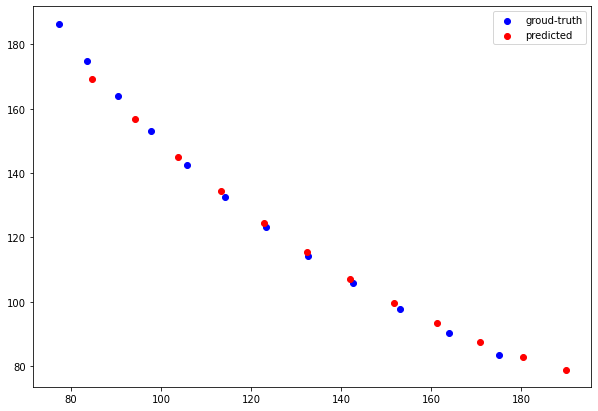

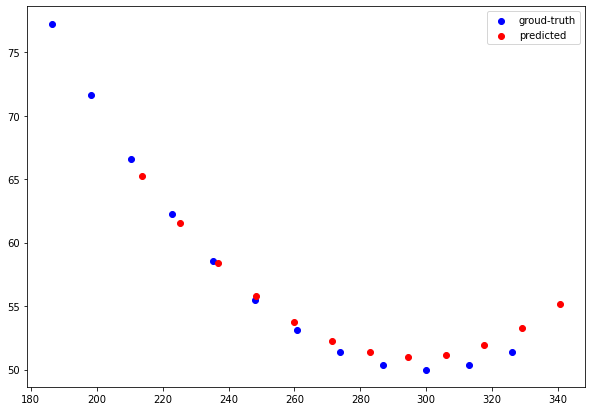

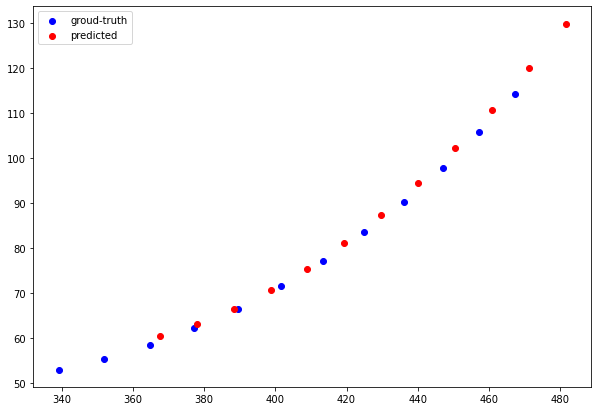

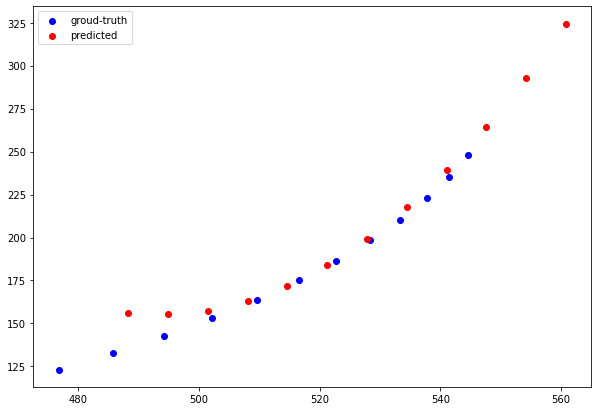

In [26]:
for i in range(9):
    plt.scatter(full_gt[i][:,0], full_gt[i][:,1], color='blue', label ='groud-truth')
    plt.scatter(full_pr[i][:,0], full_pr[i][:,1], color='red', label ='predicted')
    plt.legend()
    plt.show()